# Intelligent Data Analysis Assignment2

## Introduction
- Purpose: 
    - Develop an online AUC maximization for highly imbalanced binary classification problem
- Intention
    - Running time limits, **10 seconds**.
    - Use the validated parameter in final submitted code. Trying other hyperparameters offline. 
    - Preprocessing the data is also useful to improve the performance. 
    - **Numpy** is available. 
    - No need to run many iterations since overfitting may occur otherwise.

## Details
- Tasks: implement an **online AUC maximization** algorithm
    - The assignment contains 3 steps: pre-process the data, develop the algorithm and apply it to the dataset.
- Pre-process:
    - Load data "train.mat", using scipy.io.loadmat
    - Using functions in sklearn.Preprocessing to do some normalization, e.g., either MinMaxScaler, or normalize or both
    - Report AUC of the model on test dataset. The AUC score of a model can be calculated by **metrics.roc_curve** and **metrics.auc** provided by sklearn.
    - Using cross-validation on training data for validating parameters. "test.mat" will be published after the submission is finished.
   
## Requirement
- The code should accept the path of the data file as input
```shell
python exp.py ./train.mat
```
- Output the AUC score of the output model on the testing data
```shell
AUC Score: 0.98
```
- The provided package should contain: report + source code
- Report:
    - How you pre-process the data
    - The details of implementing the algorithm, i.e., the algorithm description, pseudo-code, the calculation of stochastic gradients
    - The results. Other than the AUC score of the output model, I would suggest you to report the time-versus-auc curve to illustrate how the AUC score change with the execution time
    - Free to use English or Chinese
    - Only allow the standard package contained in Anaconda 3, e.g., numpy, scipy, sklearn, matplotlib and so on.

## Reference
- W. Gao, R. Jin, S. Zhu, and Z.-H. Zhou. One-pass auc optimization. In International Conference on Machine Learning, pages 906-914, 2013.
- M. Liu, X. Zhang, Z. Chen, X. Wang, and T. Yang. Fast stochastic auc maximization with o (1/n)-convergence rate. In International Conference on Machine Learning, pages 3195-3203, 2018.
- M. Natole, Y. Ying, and S. Lyu. Stochastic proximal algorithms for auc maximization. In International Conference on Machine Learning, pages 3707-3716, 2018.
- Y. Ying, L. Wen, and S. Lyu. Stochastic online auc maximization. In Advances in neural information processing systems, pages 451-459, 2016.
- P. Zhao, S. C. Hoi, R. Jin, and T. YANG. Online auc maximization. 2011.

## load training data

In [128]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import time

In [129]:
raw_data = loadmat("data/train.mat")
raw_x = raw_data['x_tr']
raw_y = raw_data['y_tr']
n_total = len(raw_x)

## preprocessing

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
scaler = MinMaxScaler()
scaler.fit(raw_x)
scaler.transform(raw_x)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

## spliting

- Using cross-validation, **10-fold cross validation**

In [132]:
from sklearn.model_selection import train_test_split

In [133]:
# add bias
bia = np.ones((len(raw_y), 1))
raw_x_bias = np.hstack((raw_x, bia))

In [134]:
# split data set in 10 parts
x_data = []
y_data = []
x_, y_ = raw_x_bias, raw_y
for fold in range(9, 0, -1):
    x_, x_split, y_, y_split = train_test_split(x_, y_, test_size=(1.0 / (fold + 1)))
    x_data.append(x_split)
    y_data.append(y_split)
x_data.append(x_)
y_data.append(y_)

## Online AUC maximization algorithm

In [135]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

In [136]:
def updateBuffer(buff, x, n_buff, n_buff_t):
    if(len(buff) < n_buff):
        buff.append(x)
    else:
        z = np.random.random()
        if(z < float(n_buff / n_buff_t)):
            idx = np.random.randint(0, len(buff))
            buff[idx] = x
    return buff

def updateClassifier(w, x, y, C, buff):
#     w_new = w
    for sample in buff:
        if(y * np.dot(w.T, (x - sample)) <= 1):
            grad = C * y * (x - sample) / 2
            grad = grad[:, np.newaxis]
#             w_new = w_new + grad
            w = w + grad
#     return w_new
    return w

def onlineAucMaximum(x, y, n_pos, n_neg, C = 1.0):
    w = np.zeros((x.shape[1], 1))
    n_pos_t = 0
    n_neg_t = 0
    b_pos = []
    b_neg = []
    for idx in range(len(y)):
        if(y[idx] == 1):
            n_pos_t += 1
            C_t = C * max(1, n_neg_t / n_neg)
            b_pos = updateBuffer(b_pos, x[idx], n_pos, n_pos_t)
            w = updateClassifier(w, x[idx], y[idx], C_t, b_neg)
        else:
            n_neg_t += 1
            C_t = C * max(1, n_pos_t / n_pos)
            b_neg = updateBuffer(b_neg, x[idx], n_neg, n_neg_t)
            w = updateClassifier(w, x[idx], y[idx], C_t, b_pos)
    return w

def onlineAucMaximumAnimation(x_train, y_train, x_test, y_test, n_pos, n_neg, C = 1.0):
    w = np.zeros((x_train.shape[1], 1))
    n_pos_t = 0
    n_neg_t = 0
    b_pos = []
    b_neg = []
    acc_t = [0.00]
    aucs = []
    y_pre = np.dot(x_test, w)
    fpr, tpr, thresholds = roc_curve(y_test, y_pre)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    for idx in range(len(y_train)):
        start = time.time()
        if(y_train[idx] == 1):
            n_pos_t += 1
            C_t = C * max(1, n_neg_t / n_neg)
            b_pos = updateBuffer(b_pos, x_train[idx], n_pos, n_pos_t)
            w = updateClassifier(w, x_train[idx], y_train[idx], C_t, b_neg)
        else:
            n_neg_t += 1
            C_t = C * max(1, n_pos_t / n_pos)
            b_neg = updateBuffer(b_neg, x_train[idx], n_neg, n_neg_t)
            w = updateClassifier(w, x_train[idx], y_train[idx], C_t, b_pos)
        end = time.time()
        acc_t.append(acc_t[-1] + end - start)
        y_pre = np.dot(x_test, w)
        fpr, tpr, thresholds = roc_curve(y_test, y_pre)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    return w, acc_t, aucs

In [137]:
x_train = np.concatenate((x_data[0:9]))
y_train = np.concatenate((y_data[0:9]))
x_test = x_data[9]
y_test = y_data[9]

### hyperparameters

In [138]:
N_BUFF_POS = 200
N_BUFF_NEG = 200
C = 15

Training episode 0
Prediction episode 0
Training episode 1
Prediction episode 1
Training episode 2
Prediction episode 2
Training episode 3
Prediction episode 3
Training episode 4
Prediction episode 4
Training episode 5
Prediction episode 5
Training episode 6
Prediction episode 6
Training episode 7
Prediction episode 7
Training episode 8
Prediction episode 8
Training episode 9
Prediction episode 9


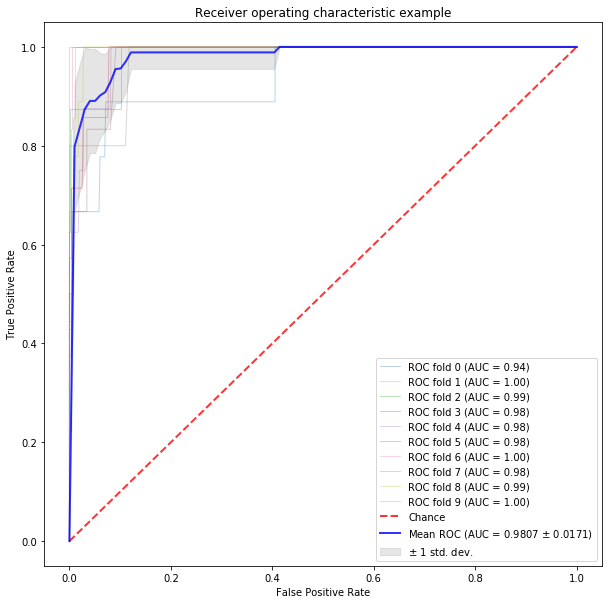

In [139]:
def analysis(y_pre, y, thresholds):
    TP, FP, TN, FN = 0, 0, 0, 0
    for idx in range(len(y)):
        if(y[idx] >= thresholds):
            if(y_pre[idx] >= thresholds):
                TP += 1
            else:
                FN += 1
        if(y[idx] < thresholds):
            if(y_pre[idx] >= thresholds):
                FP += 1
            else:
                TN += 1
    acc = float(TP + TN) / len(y)
    prec = float(TP) / (TP + FP)
    rec = float(TP) / (TP + FN)
    return acc, prec, rec
    
w_list = []
acc_list = []
prec_list = []
rec_list = []
tprs = []
aucs = []
acc_t = []
auc_t = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(1, figsize=(10,10))

# 10 times training
for fold in range(10):
    tmp = range(fold) + range(fold+1,10)
    x_test = x_data[fold]
    y_test = y_data[fold]
    x_train = x_data[tmp[0]]
    y_train = y_data[tmp[0]]
    for idx in range(1, 9):
        x_train = np.concatenate((x_train, x_data[idx]))
        y_train = np.concatenate((y_train, y_data[idx]))
    # train
    print("Training episode %d"%(fold))
    w, t_, auc_ = onlineAucMaximumAnimation(x_train, y_train, x_test, y_test, N_BUFF_POS, N_BUFF_NEG, C)
    acc_t.append(t_)
    auc_t.append(auc_)
    w_list.append(w)
    # predict
    print("Prediction episode %d"%(fold))
    y_pre = np.dot(x_test, w_list[fold])
    acc, prec, rec = analysis(y_pre, y_test, 0.0)
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    # for auc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pre)
    roc_auc = auc(fpr, tpr)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [140]:
acc_t[0].append(acc_t[1][-1])
auc_t[0].append(auc_t[0][-1])

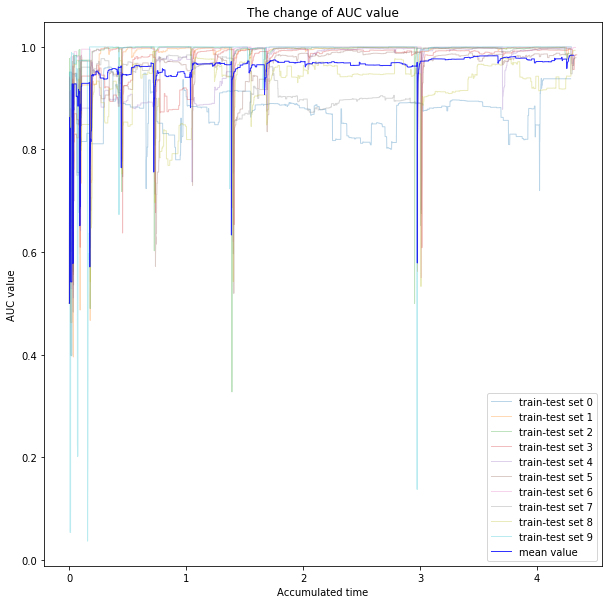

In [141]:
acc_t_mean = np.mean(np.array(acc_t), axis=0)
auc_t_mean = np.mean(np.array(auc_t), axis=0)

plt.figure(2, figsize=(10,10))
for fold in range(10):
    plt.plot(acc_t[fold], auc_t[fold], lw=1, alpha=0.3,
             label='train-test set %d' % (fold))
plt.plot(acc_t_mean, auc_t_mean, color='b', alpha=.8, lw=1, label="mean value")
plt.xlabel('Accumulated time')
plt.ylabel('AUC value')
plt.title('The change of AUC value')
plt.legend(loc="lower right")
plt.show()

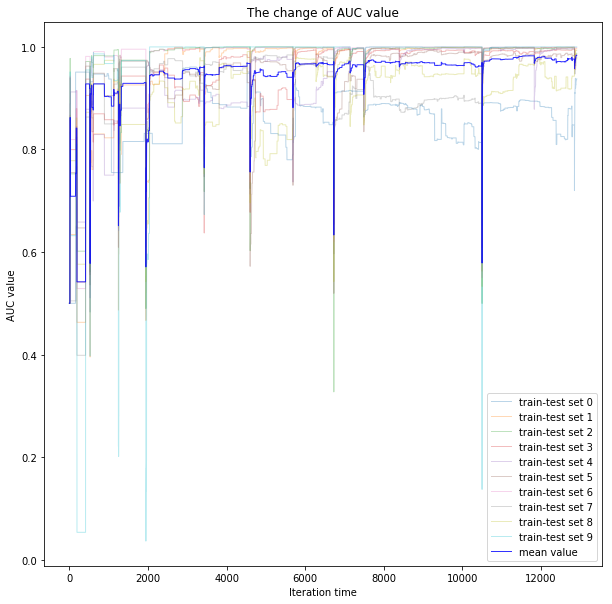

In [142]:
plt.figure(3, figsize=(10,10))
for fold in range(10):
    plt.plot(range(len(auc_t[fold])), auc_t[fold], lw=1, alpha=0.3,
             label='train-test set %d' % (fold))
plt.plot(range(len(auc_t_mean)), auc_t_mean, color='b', alpha=.8, lw=1, label="mean value")
plt.xlabel('Iteration time')
plt.ylabel('AUC value')
plt.title('The change of AUC value')
plt.legend(loc="lower right")
plt.show()

In [143]:
print(mean_auc)
print(std_auc)

0.9806985525178566
0.017121434180258466


In [144]:
print(len(acc_t[0]), len(auc_t[0]))

(12908, 12908)
